In [1]:
import os
import glob
import pickle

import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter as smooth
import statsmodels.formula.api as smf
import warnings
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib.patches import Rectangle
#%matplotlib inline


    
### you might need to change the line below if you want to regenerate the figure on a differente computer 
### Below we will run some preprocessing notebooks. In our case, our preprocessing notebooks are located in 
### a folder ("load_preprocess_mouse") which is at the same level that the folder that contain the notebooks 
### that generate the figures (for instance this one)


notebookPath=os.path.dirname(os.path.realpath("__file__"))
pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_mouse")
os.chdir(pathToProcessingNotebooks)   
%run loadMouse_documentation.ipynb
%run loadRawSpike_documentation.ipynb
%run plotMouse_Behavior.ipynb


#######

def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False

def cm2inch(value):
    return value/2.54
    

#Those parameters are overwritten if there is a .behav_param file
paramCarola={
    "distanceToRun":100,
    "maxTrialDuration": 60,
    "valveONTime":50,
    "minInterTrialDuration":15,
    "immobilityDuration":2,
    #to read .eeg (put None to not read .eeg)
    "nChannelElectro":32, #32
    "channel_opto": -6, #not used
    "channel_lickBreak":-5,
    "channel_reward": -4, #not used currently
    "channel_sound": -3, #not used
    "channel_trialON": -2,
    "channel_beamBreak": -1,
}    


#### root is the path to the folder where the data (MOUXXX, MOUXXY, ....ALLMOU_Analysis) are located
### you might need to change the line below depending on your computer orgnization

    
if platform.system()=='Linux':
    root="/data"
else:
    root="/Users/davidrobbe/Documents/Data/"

print("The path to data is %s"%root)
    
paramCarola={
        "distanceToRun":100,
        "maxTrialDuration": 60,
        "valveONTime":50,
        "minInterTrialDuration":15,
        "immobilityDuration":2,
        #to read .eeg (put None to not read .eeg)
        "nChannelElectro":32, #32
        "channel_opto": -6, #not used
        "channel_lickBreak":-5,
        "channel_reward": -4, #not used currently
        "channel_sound": -3, #not used
        "channel_trialON": -2,
        "channel_beamBreak": -1,
    }

savePath=os.path.join(root,"ALLMOU_Analysis","FigForMS")

ERROR: File `'plotMouse_SpikingActvity.ipynb.py'` not found.


The path to data is /data


In [2]:
%run plotMouse_SpikingActivity.ipynb

In [3]:
def correlationFrateVsSpeedForFig(data,shank,cluster,runType="all",redoModulation=False,showplot=True,excludeDrift=False,gridinfo=None):
    
    if excludeDrift:
        beg_end=removeDriftTrials(data,shank,cluster,printOutput=False)[2]
    else:
        beg_end=[]
    
    fRateCorrelationsWith={
            "runningSpeedDuringModulatedEpoch":{},
            "AccelDuringModulatedEpoch":{},
            "RunDistance":{},
            "RunDuration":{}
            }
    
    
    if gridinfo is None:
        fig = plt.figure(figsize=(10,3))
        gs1 = gridspec.GridSpec(1, 2)
        gs1.update(wspace=0.5)
        ax1=fig.add_subplot(gs1[0])
    else:
        fig=plt.gcf()
        ax1=fig.add_subplot(gridinfo[0])



    ## load if exist and not redoModulation the saved modulation data
    picklePath=os.path.join(root,data.animal,"Experiments",data.experiment,"Analysis","ModulationDuring" +  runType.replace(" ","") + "Runs.p")
    #print(picklePath)

    if os.path.exists(picklePath) and not redoModulation:
        modulationResults=pickle.load(open(picklePath,"rb"))
        print("spiking modulation  data loaded from %s"%picklePath)

        if (modulationResults["BiggestModulationSign"][shank][cluster]=="not modulated") or (modulationResults["BiggestModulationSign"][shank][cluster]=="not enough spikes"):
            fRateCorrelationsWith={
            "runningSpeedDuringModulatedEpoch":[],
            "AccelDuringModulatedEpoch":[],
            "RunDistance":[],
            "RunDuration":[]
            }
            
            
            if not showplot:
                plt.close()
            return fRateCorrelationsWith

        # get and plot behavioral and neural data for all the behaviral epochs
        plotaxinfo,meanFiring,nSideBin,spikeHist,allSpeed,allDuration = plot_normalized_running_periods_firing_rate(data,shank,cluster,
                                                                        binSize=0.25,SideLength=3,runType=runType,ax=ax1,beg_end=beg_end)
        modulatedBins=modulationResults["BiggestModulationIndexes"][shank][cluster]
        plotaxinfo.plot([i+0.5 for i in modulatedBins],meanFiring[modulatedBins],'or')
        


    else:
        modulationResults,spikeHist,allSpeed,allDuration,nSideBin,plotaxinfo=GetModulatedPortionsDuringRun(data,shank,cluster,
                                                                            runType="all",printoutput=False,plotoutput=True,ax=ax1,excludeDrift=excludeDrift)
        
                
        if (modulationResults["BiggestModulationSign"]=="not modulated") or (modulationResults["BiggestModulationSign"]=="not enough spikes"):
            fRateCorrelationsWith={
            "runningSpeedDuringModulatedEpoch":[],
            "AccelDuringModulatedEpoch":[],
            "RunDistance":[],
            "RunDuration":[]
            }
            
            
            if not showplot:
                plt.close()
            return fRateCorrelationsWith
        
        
        modulatedBins=modulationResults["BiggestModulationIndexes"]

    
    ### change axes appearance for fig plot
    plotaxinfo[0].set_ylabel('Speed (cm/s)', fontsize=12)
    plotaxinfo[1].set_ylabel('Firing rate \n (Hz)', fontsize=12)
    plotaxinfo[1].spines['top'].set_visible(False)
    plotaxinfo[1].xaxis.set_ticks_position('bottom')
#     plotaxinfo[1].xaxis.set_label_coords(0.5, -0.025)
   
    
    
    for singleaxinfo in plotaxinfo:
            singleaxinfo.spines['top'].set_visible(False)
            singleaxinfo.xaxis.set_ticks_position('bottom')
            singleaxinfo.set_title('')
            singleaxinfo.set_xlabel('Run phase',fontsize=12)
            singleaxinfo.xaxis.set_label_coords(0.5,-0.2)
            
            singleaxinfo.set_xticks([nSideBin,len(spikeHist[0])/2,len(spikeHist[0])-nSideBin])
            singleaxinfo.set_xticklabels(["start","","end"])
            singleaxinfo.locator_params(axis='y',nbins=4)
            singleaxinfo.tick_params(axis='x',direction='out')
            
    
    plotaxinfo[1].axvspan(modulatedBins[0], modulatedBins[-1], facecolor="tomato",edgecolor="none",alpha=0.5)                                 
    
    plotaxinfo[1].lines.pop(-1)
    plotaxinfo[1].lines.pop(-1)
    
    #print("shape of spikeHist: %s, %s" %(spikeHist[0],spikeHist[1]))
            
            
            
    
    # trial by trial scatter plot speed vs firing rate


    fRateDuringModulatedEpoch=[]
    runningSpeedDuringModulatedEpoch=[]
    #print("number of epoch %s" %len(allDuration))
    for x,r in enumerate(allDuration):
        if sum(spikeHist[x][modulatedBins])>=0:
            
            #frate trial by trial
            fRateDuringModulatedEpoch.append(np.nanmean(spikeHist[x][modulatedBins]))

            #running speed
            runningSpeedDuringModulatedEpoch.append(np.nanmean(allSpeed[x][modulatedBins]))




    if gridinfo is None:
        ax2=fig.add_subplot(gs1[1])
    else:
        ax2=fig.add_subplot(gridinfo[1])





    x=fRateDuringModulatedEpoch
    y=runningSpeedDuringModulatedEpoch
    
    
        
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit) 

    ax2.plot(x,y, 'ro', x, fit_fn(x), '-r',linewidth=2,markeredgecolor='r')
    ax2.set_xlabel("Firing rate (Hz)",fontsize=12,)
    ax2.xaxis.set_label_coords(0.5,-0.2)
    ax2.set_ylabel("Speed (cm/s)",fontsize=12)
    ax2.yaxis.set_label_coords(-0.15,0.45)
    ax2.locator_params(axis='y',nbins=4)
    ax2.locator_params(axis='x',nbins=3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')
    ax2.yaxis.set_ticks_position('left')

    MinMaxForPlot=np.percentile(y,[2,98])
    ax2.set_ylim(MinMaxForPlot)
    SpearManResults=stats.spearmanr(x,y)
    rvalue=str(round(SpearManResults[0],2));
    if SpearManResults[1]<0.0001:
        pvalue="p<0.0001"
    else:
        pvalue="p="+ str(round(SpearManResults[1],4))

    title="r=%s, %s"%(rvalue,pvalue)
    #ax2.set_title(title,fontsize=20,weight="bold")
   
   

   

    if not showplot:
        plt.close()
    
    return modulationResults,plotaxinfo

In [4]:
def modifyAxesForFig(ax,xlabel,ylabel):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel(ylabel,fontsize=12)
    ax.locator_params(axis='x',nbins=4)
    ax.set_title("")
    

In [18]:
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))
#-------------------------------------------------
def plot_principal_components(tuningDict,nc,colors):
    '''
    tuningDict = dict of normalized mean firing rates
    nc = number of component to consider in PCA
    '''
    q = tuningDict
    nbins = len(q[0])
    from sklearn.decomposition.pca import PCA
    q=np.array(list(q.values()))
    for i in range(len(q)):
        q[i,:]=normalize(q[i,:])
    pca1 = PCA(n_components=nc)
    pca1.fit(q)
    print("n=2, explained variance: ",np.sum(pca1.explained_variance_ratio_)) 
    for i in range(nc):
        v=pca1.components_[i]
        plt.plot(v,colors[i], label="c "+np.str(i+1))

    #plt.plot(v2,"g--")
    ax = plt.gca()
    ax.set_xticks([0,nbins-1],["Beg","End"])
    ax.set_xlim(0,nbins-1)
    ax.set_xlabel("Run phase",fontsize=12)
    ax.set_ylabel("Loading",fontsize=12)
    #plt.legend(loc="best",fontsize=8)
    #plt.plot(v2,"gray")
    #plt.yticks(np.arange(-0.3,0.4,0.1))
    print(len(v))
#-----------------------------------------------------------
def quadraticFit_stats(tuning_clu):
    nbins=len(tuning_clu)
    xdata = np.arange(nbins)
    #As an added benefit centering the x variable reduces the correlation between the linear and quadratic terms.
    #The correlation between x and x2 is 0.975 while the correlation between c and c2 is 0.000.==>
    xdata=xdata-np.mean(xdata)
    ydata=normalize(tuning_clu)
    d={'x':xdata,"y":ydata}
    model = smf.ols(formula = 'y ~ np.power(x,2)+x',data=d).fit()
    b,a,pb,pa=model.params["x"],model.params['np.power(x, 2)'],model.pvalues["x"],model.pvalues['np.power(x, 2)']
    c = model.params["Intercept"]
    return [a,b,pa<=0.05,pb<=0.05,c]
#--------------------------------------------------------------
def test_quadraticVslinear(a,b,c,pa,pb,x):
        y=a*x*x+b*x+c
        if pa and (not pb):
            if a>0 :#and np.abs(b/(-2*a))<1:
                    test="QuadraticConvexe"
            else:
                    test="QuadraticConcave"
        #elif  pb and (not pa):
        #    if b>0:
        #       test="Increasing"
        #    else:
        #        test="Decreasing"
        elif pb:#elif pb and pa:      
            if a>0:
                if y[0]<y[-1]:
                    test="QuadraticConvexeUp"
                else:
                    test="QuadraticConvexeDown"
            else:
                if y[0]>y[-1]:
                    test="QuadraticConcaveDown"
                else:
                    test="QuadraticConcaveUp"
        else:
            test="none"
        return test,y
#---------------------------------------------------
def classify_cells(clu_quadraticFit,xdata):
    #increasing =[]
    #decreasing =[]
    onset=[]
    offset=[]
    negOnset=[]
    negOffset=[]
    duration=[]
    onoff=[]
    none=[]
    for c in clu_quadraticFit:
        a,b,pa,pb,intercept=clu_quadraticFit[c]
        test,y=test_quadraticVslinear(a,b,intercept,pa,pb,xdata)
        if test=="QuadraticConcave":duration=np.append(duration,c)
        elif test=="QuadraticConcaveUp":negOffset=np.append(negOffset,c)
        elif test=="QuadraticConvexeUp":offset=np.append(offset,c) 
        elif test=="QuadraticConcaveDown":negOnset=np.append(negOnset,c) 
        elif test=="QuadraticConvexeDown":onset=np.append(onset,c)
        elif test=="QuadraticConvexe":onoff=np.append(onoff,c)
        else:none=np.append(none,c)
    #return onset,negOffset,offset,negOnset,onoff,duration,none
    return onoff,onset,negOnset,duration,negOffset,offset,none

def FindCellIndexInGroups(CellIndex,Groups):
    for index,CellIDs in enumerate(Groups):
        if CellIndex in CellIDs:
            return(index)
        
def plot_figureClasses(X,clu_quadraticFit_WT,xdata,nSideBin):
    from matplotlib.patches import Rectangle
   
    plt.imshow(X,interpolation="bilinear",aspect="auto",origin="low",cmap="Reds")
    ax = plt.gca()
    ax.tick_params(axis='both',which='major',width=2)
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    #ax.spines['bottom'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    #ax.xaxis.set_ticks_position('none')
    ax.set_xticks([nSideBin,X.shape[1]/2,X.shape[1]-nSideBin])
    ax.get_xaxis().set_tick_params(direction='out')
    ax.get_yaxis().set_tick_params(direction='out')
    ax.axvline(nSideBin,color="orange",linestyle='--',linewidth=2)
    ax.axvline( X.shape[1]-nSideBin,color="orange",linestyle='--',linewidth=2)
    
    
    ax.set_xlabel("Run phase",fontsize=12)
    ax.set_xticklabels(["start","","end"])
    ax.set_yticks(np.arange(0,len(clu_quadraticFit_WT),20))
    ax.set_ylabel('Cells + (sorted)',fontsize=12)
    names=["On/off","Onset(+)","Onset(-)","Duration",
           "Offset(-)","Offset(+)","Other"]
    colors=["goldenrod","darkgreen","lightgreen","brown","lightblue","darkblue","gray"]
    s0=0
    s1=0
    #plt.plot([53,55],[s0,s0],"k")
    cpt=0
    for i in classify_cells(clu_quadraticFit_WT,xdata)[0:-1]:
        if  len(i)==0:
            cpt+=1
        else:
            s0=s1
            s1+=(len(i))
            pad=-1
            colorbarsize=2
            plt.plot([X.shape[1]+pad,X.shape[1]+pad],[s0,s1],"w")
            ax.add_patch(Rectangle((X.shape[1]+pad, s0), colorbarsize, s1-s0, facecolor=colors[cpt]))
            plt.plot([X.shape[1]+pad,X.shape[1]+pad+colorbarsize],[s1,s1],"w")
            plt.text(X.shape[1]+pad+colorbarsize+0.5, s0+(s1-s0)/4., names[cpt], ha='left', va='bottom', rotation=30)
            cpt+=1
    ax.set_ylim(0,s1)
    ax.set_xlabel("Run phase")
    clear_output()
#---------------------------------------------------------------------------------
def illustrate_classes(tuningWithoutBorder,tuningWithBorders,nSideBin,ind,Groups,xdata,plotcellindex=False):
    ydata =tuningWithoutBorder[ind]
    ydatatoplot=normalize(tuningWithBorders[ind])
    n=len(ydata)
    xdata=xdata-np.mean(xdata)
    ydata=normalize(ydata)
    d={'x':xdata,"y":ydata}
    model = smf.ols(formula = 'y ~ np.power(x,2)+x',data=d).fit()
    b,a,pb,pa=model.params["x"],model.params['np.power(x, 2)'],model.pvalues["x"],model.pvalues['np.power(x, 2)']
    #print("b=%s,a=%s,pb=%s,pa=%s" %(b,a,pb,pa))
    c = model.params["Intercept"]
    ax=plt.gca()
    ax.set_xlabel("Run phase",fontsize=12)
    ax.set_ylabel("Normalized \n firing rate",fontsize=12)
    xaxis=np.arange(nSideBin,nSideBin+len(ydata))
    #plt.plot(xaxis,model.predict(),"c",lw=4)
    ax.set_xticks([nSideBin,nSideBin+len(ydata)],["start","end"])
    #plt.xlim(0,n-1)
    ax.set_ylim(0,1.1)
    ax.set_yticks([0,1],["min","max"])
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    #plt.fill_between(np.arange(len(ydatatoplot)),np.zeros(len(ydatatoplot)),ydatatoplot,color=colorfill)
    ax.axvspan(nSideBin, nSideBin+len(ydata), facecolor="orange",edgecolor="none",alpha=0.5)
    ax.plot(ydatatoplot,color='red',linewidth=2,alpha=0.5)
    
    names=["On/off","Onset(+)","Onset(-)","Duration","Offset(-)","Offset(+)","Other"]
    colors=["goldenrod","darkgreen","lightgreen","brown","lightblue","darkblue","gray"]
    groupIndex=FindCellIndexInGroups(ind,Groups)
    ax.plot(xaxis,model.predict(),color=colors[groupIndex],lw=4,linestyle='--')
    #plt.title(names[groupIndex]+ " cell id= %s" %ind,color=colors[groupIndex])
    if plotcellindex:
        titleName=names[groupIndex]+ " cell id= %s" %ind        
    else:
        titleName=names[groupIndex]
        
    ax.set_title(titleName,color=colors[groupIndex],fontweight='bold')
    #print(test_quadraticVslinear(a,b,0,pa,pb,xdata)[0])


    
    #clear_output()


In [28]:
def plotallcells(SortedNormFiringRatesAs2DArray,nSideBin=12,showXlabel=True,Ylabel="Units"):
    
    
    plt.imshow(SortedNormFiringRatesAs2DArray,interpolation="bilinear",aspect="auto",origin="low",cmap="Reds")
    
    #plt.pcolormesh(timebin,y,SortedNormFiringRatesAs2DArray,cmap="Reds")
    ax = plt.gca()
    #plt.xlim(0,timebin[-1])
    plt.ylim([0,SortedNormFiringRatesAs2DArray.shape[0]])
    plt.tick_params(axis='both',which='major',width=2)
    plt.ylabel(Ylabel,fontsize=12)
    ax.set_yticks(np.arange(0,SortedNormFiringRatesAs2DArray.shape[0],20))
    
    if showXlabel:    
        plt.xlabel("Run phase",fontsize=12)
        ax.set_xticklabels(["start","","end"])
    else:
        ax.set_xticklabels([])
    
    plt.axvline(nSideBin,color="orange",linestyle='--',linewidth=2)
    plt.axvline( SortedNormFiringRatesAs2DArray.shape[1]-nSideBin,color="orange",linestyle='--',linewidth=2)
    #ax = plt.gca()   
    ax.set_xticks([nSideBin,SortedNormFiringRatesAs2DArray.shape[1]/2,SortedNormFiringRatesAs2DArray.shape[1]-nSideBin])
    ax.get_xaxis().set_tick_params(direction='out')
    ax.get_yaxis().set_tick_params(direction='out')
    
    ax.yaxis.set_ticks_position('left')
    #ax.xaxis.tick_top()
    ax.tick_params(labelbottom='on',labeltop='off')
    ax.xaxis.set_label_position('bottom')
    ax.set_ylim([0,SortedNormFiringRatesAs2DArray.shape[0]-0.5])

In [20]:
## Part II: Calculate the mean duration of the run epochs for all the units accross sessions to normalize run duration accross session


behaviorType=["Runs","all"]
tagList = ["GoodPerfo"]
TargetStrings=["positive","negative"]
#list of all animals
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]





### loop throught the session to find the length of average firing rate for the different sessions


RunDurationAccrossAllUnits=[]
TotalSessionIncluded=0
TotalUnitIncluded=0



#loop on animal
for animal in animalList:

    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)   

    #loop through sessions and load pickle file
    for index,session in enumerate(sessionList):


        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                           
        
        
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        picklePath=os.path.join(analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") + behaviorType[0] + ".p")
        FiringRatesModulation=pickle.load(open(picklePath,"rb"))
        
        
        for shank in FiringRatesModulation["MeanFiringRateZscored"]:
            for cluster in FiringRatesModulation["MeanFiringRateZscored"][shank]:
                if FiringRatesModulation["BiggestModulationSign"][shank][cluster] in TargetStrings:
                    RunDurationAccrossAllUnits.append(len(FiringRatesModulation["insideBehaviorIndexes"][shank][cluster]))
                    
nSideBin=FiringRatesModulation["insideBehaviorIndexes"][shank][cluster][0]
MedianRunDurationAccrossAllUnits=np.median(RunDurationAccrossAllUnits)
print("number of units %s" %(len(RunDurationAccrossAllUnits)))
print("median duration of runs %s" %MedianRunDurationAccrossAllUnits)


## Part III:  ReNormalize Firing rate in the time domain (versus median run duration)

### Can select units that have been determined to have a postive or negative modulation during run using the function GetModulatedPortionsDuringRun


def normalizeFiringRateInTime(ThisFiringRateModulation,insideRunBins,MedianRunDurationAccrossAllUnits,SignifiantModulatinIndexes):
    
    RunMeanFiringRate=ThisFiringRateModulation[insideRunBins]
    RunIndexes=range(len(RunMeanFiringRate))
    RunIndexesInterp=np.arange(0,float(RunIndexes[-1])+float(RunIndexes[-1])/float(MedianRunDurationAccrossAllUnits-1),float(RunIndexes[-1])/float(MedianRunDurationAccrossAllUnits-1))
    if len(RunIndexesInterp)>MedianRunDurationAccrossAllUnits:
        RunIndexesInterp=np.asarray([x for x in RunIndexesInterp if x <= float(RunIndexes[-1])])

    # do the itnerpolation
    RunMeanFiringRateNorm=np.interp(RunIndexesInterp,RunIndexes,RunMeanFiringRate)
    # reconcatenate the borders
    RunNormFiringRate=np.concatenate([ThisFiringRateModulation[0:insideRunBins[0]],RunMeanFiringRateNorm,ThisFiringRateModulation[insideRunBins[-1]+1:]],axis=0)

    
    # find the significant modulation on time normalized data
    AllIndexes=list(range(len(ThisFiringRateModulation)));
    AllINdexesInterpt=np.concatenate([AllIndexes[:insideRunBins[0]],RunIndexesInterp+insideRunBins[0],AllIndexes[-insideRunBins[0]:]],axis=0)
    
    #Get the border of the modulation
    Borders=contiguous_regions(np.asarray([X in SignifiantModulatinIndexes for X in AllIndexes])).tolist()
    InterpolatedSignificantIndexes=[]
    for startstop in Borders:
        InterpolatedSignificantIndexes.append([index for index,value in enumerate(AllINdexesInterpt) if (value>=startstop[0] and value<=startstop[1])])
    
    return RunNormFiringRate,InterpolatedSignificantIndexes
    
    
    
    

# loop across data to normalize length of mean firing rate across session
# keep cells that have a modulation sign according to TargetString

#animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]
tagList = ["GoodPerfo"]
TargetStrings=["positive","negative"]
AllFiringRates=[]
NumberOfPositivelyModulatedCell=0
NumberOfNegativelyModulatedCell=0
for animal in animalList:


    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    
  

    #loop through sessions
    for index,session in enumerate(sessionList):
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        picklePath=os.path.join(analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") + behaviorType[0] + ".p")
        if os.path.exists(picklePath):
            #print(picklePath)
            FiringRatesModulation=pickle.load(open(picklePath,"rb"))
            
            for shank in FiringRatesModulation["MeanFiringRate"]:
                for cluster in FiringRatesModulation["MeanFiringRate"][shank]:
                    if FiringRatesModulation["BiggestModulationSign"][shank][cluster] in TargetStrings:
                        insideRunBins=FiringRatesModulation['insideBehaviorIndexes'][shank][cluster]
                        ThisFiringRateModulation=FiringRatesModulation["MeanFiringRate"][shank][cluster]
                        SignifiantModulatinIndexes=FiringRatesModulation["AllSignificantModulationIndexInBehaviorSameSignThanBiggest"][shank][cluster]
                        RunNormFiringRate,InterpolatedSignificantIndexes=normalizeFiringRateInTime(ThisFiringRateModulation,insideRunBins,MedianRunDurationAccrossAllUnits,SignifiantModulatinIndexes)
                           
                        
                        #find max or min and append main variables in a big list
                        if FiringRatesModulation["BiggestModulationSign"][shank][cluster]=='positive':
                            StrongestModulationIndex=np.argmax(RunNormFiringRate)
                            NumberOfPositivelyModulatedCell+=1

                        elif FiringRatesModulation["BiggestModulationSign"][shank][cluster]=='negative':
                            StrongestModulationIndex=np.argmin(RunNormFiringRate)
                            NumberOfNegativelyModulatedCell+=1
                            
                        AllFiringRates.append([StrongestModulationIndex,RunNormFiringRate,InterpolatedSignificantIndexes,session,shank,cluster,FiringRatesModulation["BiggestModulationSign"][shank][cluster]])



number of units 146
median duration of runs 28.0


## Get corr coef of all units:

In [21]:
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]
tagList = ["GoodPerfo"]
#Whether to read the existing pickle files (redo=False) or to reload from raw text files (redo=True)
redo=False
# Type of runs
runType="all"
allFiringRateVsRunSpeedCorrelations=[]
#loop on animal
for animal in animalList:
    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    #loop throught the sessions and load the saved speed vs frate correlation data in list
    for index,session in enumerate(sessionList):
        if not has_tag(root, animal, session, tagList):
            continue  
        picklePath=os.path.join(root,animal,"Experiments",session,"Analysis","FRateVsKinematciCorrDuring" + runType.replace(" ","") + "Runs.p")
        if os.path.exists(picklePath):
            CorrelationResults=pickle.load(open(picklePath,"rb"))            
            for shank in CorrelationResults["SpeedDuringModulatedEpoch"]:
                for cluster in CorrelationResults["SpeedDuringModulatedEpoch"][shank]:
                    ThisClusterCorrelationResult=CorrelationResults["SpeedDuringModulatedEpoch"][shank][cluster]
                    if ThisClusterCorrelationResult:
                        allFiringRateVsRunSpeedCorrelations.append([ThisClusterCorrelationResult,session,shank,cluster])                
        else:            
            continue


significThreshold=0.01
significantCorValues=[singleNeuronValue[0][0] for singleNeuronValue in allFiringRateVsRunSpeedCorrelations if singleNeuronValue[0][1]<=significThreshold]
unsignificantCorValues=[singleNeuronValue[0][0] for singleNeuronValue in allFiringRateVsRunSpeedCorrelations if singleNeuronValue[0][1]>significThreshold]
significantNeuronInfo=[singleNeuronValue[1:] for singleNeuronValue in allFiringRateVsRunSpeedCorrelations if singleNeuronValue[0][1]<=significThreshold]

In [22]:
CorrelationResults.keys()

dict_keys(['AccelDuringModulatedEpoch', 'RunDuration', 'SpeedDuringModulatedEpoch', 'RunDistance'])

/home/david/anaconda/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


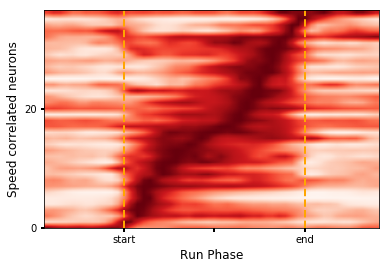

In [23]:
## find firing rates for speed correlated neurons and plot sorted/normalized for positive modulated cells

AllFiringRatesSpeedModulatedCells=[]
for FiringRateResults in AllFiringRates:
    UnitSessionShankClu=FiringRateResults[3:6]
    if [CellInfo for CellInfo in significantNeuronInfo if CellInfo==UnitSessionShankClu]:
        AllFiringRatesSpeedModulatedCells.append(FiringRateResults)
    
    

TimeSortedFiringRatesSpeedModulatedCells=sorted(AllFiringRatesSpeedModulatedCells, key=lambda firingdata: firingdata[0])
TimeSortedFiringRatesSpeedModulatedCellsAs2DArray=np.asarray([item[1]/max(item[1]) for item in TimeSortedFiringRatesSpeedModulatedCells if item[-1]=="positive"])
plotallcells(TimeSortedFiringRatesSpeedModulatedCellsAs2DArray,Ylabel="Speed correlated neurons")

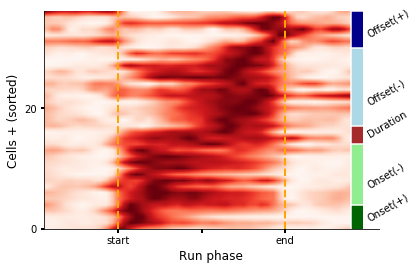

In [24]:
## FIT and Classification  for neurons that are both positive modulated AND speed correlated

AllFiringRatesPositiveModulationSpeedModulated=[FiringRate for FiringRate in AllFiringRates if ([CellInfo for CellInfo in significantNeuronInfo if CellInfo==FiringRate[3:6]]and FiringRate[-1]=='positive')]
NonSortedFiringRatesAs2DArrayPositiveModulationSpeedModulated=np.asarray([item[1] for item in AllFiringRatesPositiveModulationSpeedModulated])

# We work with the positively modulated cells. We work on the non-sorted array of all units  for the latter visualisation purpose of the classes

AlltuningMiceWithBorders = NonSortedFiringRatesAs2DArrayPositiveModulationSpeedModulated
nCells =AlltuningMiceWithBorders.shape[0]
#np.random.shuffle(AlltuningMiceWithBorders)
tuningWithBorders={}
for clu in np.arange(nCells):
    tuningWithBorders[clu] = AlltuningMiceWithBorders[clu,:]


# Then we run the quadratic decomposition using the tuning curve without the pre and post run epochs


AlltuningMiceWithoutBorder=AlltuningMiceWithBorders[:,nSideBin:-nSideBin]
tuningWithoutBorder={}
for clu in np.arange(nCells):
    tuningWithoutBorder[clu] = AlltuningMiceWithoutBorder[clu,:]

nBins=len(tuningWithoutBorder[clu] )
xdata = np.arange(0,nBins,1)
xdata = xdata -np.mean(xdata)

clu_quadraticFit={}
for clu in tuningWithoutBorder:
        clu_quadraticFit[clu]=quadraticFit_stats(tuningWithoutBorder[clu])

#classify the tuning using the modulation restricted to the run (not before and after)-
A = list(classify_cells(clu_quadraticFit,xdata))
#------------------------------------------------

## reconstruct a maxtrix X based on the classification. But  we do not use the entire tuning that is : it contains immobility before and after

X=np.zeros((nCells,AlltuningMiceWithBorders.shape[1]))
cpt=0
for i in range(len(A)):
    if len(A[i])>0:
        for c in A[i]:
            X[cpt,:]=normalize(tuningWithBorders[c])
            cpt+=1

plot_figureClasses(X,clu_quadraticFit,xdata,nSideBin)

In [25]:
for i in classify_cells(clu_quadraticFit,xdata):
    if  len(i)!=0:
        print(i)

[11. 18. 19. 31.]
[ 0.  3.  4. 12. 15. 28. 32. 33. 34. 35.]
[10. 24. 30.]
[ 1.  2.  5.  6.  7.  8.  9. 14. 20. 21. 22. 23. 26.]
[13. 16. 17. 25. 27. 36.]
[29.]


## define panel sizes in figure

In [26]:
topVSpace=0.01
bellowVSpace=0.065
leftHSpace=0.075
rightHSpace=0.975
betweenRowSpace=0.075
nRows=3
ratioRaws=[3,3,2]
vspaceForFig=1.0-(topVSpace+bellowVSpace+betweenRowSpace*(nRows-1))
#print("Total vertical space for figures: %s" %vspaceForFig)
topBottomLimits=[]
top=1
bottom=1
for rawNumber,rawRatio in enumerate(ratioRaws):
    vSpaceForRow=vspaceForFig*(rawRatio/np.sum(ratioRaws))
    print("raw %s size is %s" %(rawNumber+1, vSpaceForRow))
    if rawNumber==0:
        top-=topVSpace
        bottom-=topVSpace+vSpaceForRow
        print(top,bottom)
    else:
        top=bottom-betweenRowSpace
        bottom=top-vSpaceForRow
        print(top,bottom)
        print(rawNumber)
        if rawNumber==nRows-1:
            if np.round(bottom,2)!=np.round(bellowVSpace,2):
                print("last bottom does not match with required space")
    topBottomLimits.append([top,bottom])
print(topBottomLimits)        

raw 1 size is 0.290625
0.99 0.699375
raw 2 size is 0.290625
0.624375 0.33375
1
raw 3 size is 0.19375
0.25875 0.06499999999999997
2
[[0.99, 0.699375], [0.624375, 0.33375], [0.25875, 0.06499999999999997]]


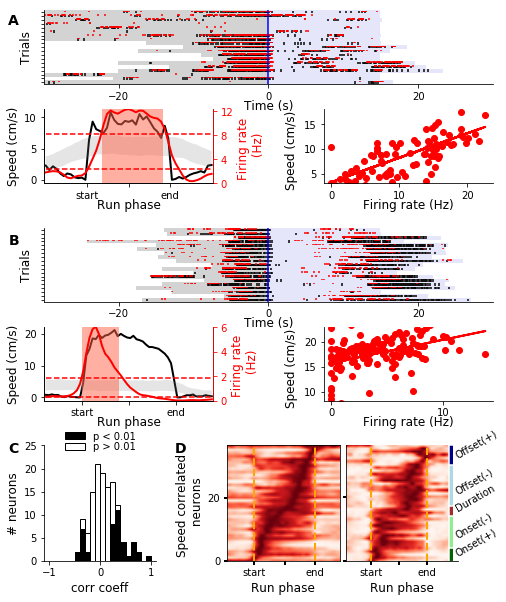

In [29]:
illustrationsForSpeedFig=[["MOU074_2015_07_23_12_16",1,34,26],["MOU035_2014_12_10_10_36",4,3,1]]
fig=plt.figure(figsize=(cm2inch(17.6),cm2inch(21)))

for index,topBottomLimit in enumerate(topBottomLimits):
    if index<nRows-1:
        SESSION=illustrationsForSpeedFig[index][0]
        ANIMAL=SESSION[0:6]
        data=Data(root,ANIMAL,SESSION,paramCarola,redoPreprocess=False)     
        shank=illustrationsForSpeedFig[index][1]
        cluster=illustrationsForSpeedFig[index][2]
        
        ## plot a few trials
        
        gs1 = gridspec.GridSpec(4, 2)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=rightHSpace, wspace=0.65,hspace=1)
        ax1 = plt.subplot(gs1[0:2, :])
        plot_break_cluster(data,shank,cluster,group="Good",legend=False)
        ax1.set_ylim([illustrationsForSpeedFig[index][-1]+19,illustrationsForSpeedFig[index][-1]])
        ax1.set_xlim([-30,30])
        ax1.set_yticklabels([""])
        ax1.xaxis.set_label_coords(0.5,-0.2)
        ax1.yaxis.set_label_coords(-0.025,0.5)
        modifyAxesForFig(ax1,"Time (s)","Trials")
        
        
        ax2 = plt.subplot(gs1[2:, :-1])
        ax3 = plt.subplot(gs1[2:, -1])
        modulationResults,plotaxinfo=correlationFrateVsSpeedForFig(data,shank,cluster,showplot=True,redoModulation=True,excludeDrift=True,gridinfo=[ax2,ax3])
        
        
#         ax3 = plt.subplot(gs1[1:, -1])
    else:
        gs1 = gridspec.GridSpec(1, 3)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=rightHSpace, wspace=0.5)
        ax1 = plt.subplot(gs1[0])
        
        
        binEdges=np.arange(-1,1.1,0.1)
        ax1.hist([significantCorValues,unsignificantCorValues],binEdges, histtype='bar', stacked=True,color=["k","w"],label=["p < 0.01","p > 0.01"],edgecolor='black');        
        modifyAxesForFig(ax1,"corr coeff","# neurons")
        ax1.get_xaxis().set_tick_params(direction='out')
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),frameon=False,labelspacing=0.05,fontsize=10)
        ax1.set_ylim([0,25])
        
        
        
        ax2 = plt.subplot(gs1[1])
        plotallcells(TimeSortedFiringRatesSpeedModulatedCellsAs2DArray,Ylabel="Speed correlated \n neurons")
        pos2=ax2.get_position()
        pos2.x0=pos2.x0+0.03
        pos2.x1=pos2.x1+0.03
        ax2.set_position(pos2)
        
        
        ax3 = plt.subplot(gs1[2])
        plot_figureClasses(X,clu_quadraticFit,xdata,nSideBin)
        ax3.set_ylabel("")
        ax3.set_yticklabels("")
        
        pos3=ax3.get_position()
        pos3.x1=pos3.x1-0.07
        pos3.x0=pos3.x0-0.07
        ax3.set_position(pos3)
        
        
figuresLabels={"A":[0.025,0.985],"B":[0.025,0.615],"C":[0.025,0.265],"D":[0.36,0.265]}
for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0],coordinates[1],label,figure=fig,weight='bold',fontsize=14,ha='right' ,va='top')
        
saveFullName=os.path.join(savePath,'RevisedFig07_SpeedCorrelations.pdf')
plt.savefig(saveFullName,orientation='landscape',dpi=600,format='pdf')

**Figure 7. A large fraction of striatal neurons displayed strong trial-by-trial correlation between firing rate and running speed. A,B)** Two illustrative neurons with significant speed-firing rate correlations. Top panels show rasters of spike times superimposed on wheel movement detections, for a few consecutive trials. Lower-left panels showed mean firing rate (red thick line) relative to run phases, superimposed on average running speed (black). Red area indicates phases with significant modulation of firing rate. Dashed red lines and gray shaded area are, respectively, the global and pointwise bands of confidence used for detecting significant modulation (see Methods section), Lower-right panels show a scatter plot of speed versus firing rate in the modulated run epochs across all trials. **C)** Distribution of Spearman correlation coefficients for all positively modulated neurons. **D)** Mean firing rate relative to run phases for all neurons with a significant correlation coefficient between firing rate and speed, ordered by the phase of the peak firing rate (left), or the coefficients of the quadratic and linear polynomial fit function (right),